#### Multiple linear regression for "Owned", using `[['rating_average', 'yearpublished', 'minplayers', 'maxplayers', 'minage', 'playingtime']]` 
#### Followed by controling for `[['yearpublished']]`, and mantaining the rest as IVs.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import scipy.stats as stats

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm #needed for Cooks distance

from tabulate import tabulate

# Load the data
ratings_data = pd.read_csv('./ratings.csv')
details_data = pd.read_csv('./details.csv')

# Rename columns in the ratings data for clarity
ratings_data_renamed = ratings_data.rename(columns={
    'rank': 'rating_rank',
    'average': 'rating_average',
    'bayes_average': 'rating_bayes_average',
    'users_rated': 'rating_users_rated'
})

# Merge the datasets on 'id' and 'num'
combined_data = pd.merge(ratings_data_renamed, details_data, on=['id'], suffixes=('_rating', '_details'))

# Drop unnecessary columns
columns_to_drop = ['url', 'thumbnail', 'description', 'boardgamepublisher', 'boardgamedesigner', 'boardgameartist']
cleaned_data = combined_data.drop(columns=columns_to_drop)

# Convert categorical data to numeric format using one-hot encoding
# cleaned_data = pd.get_dummies(cleaned_data, columns=['boardgamecategory', 'boardgamemechanic', 'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation'])
# cleaned_data = cleaned_data.drop(['boardgamecategory', 'boardgamemechanic', 'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation'], axis=1)

# Check for duplicates and drop them
cleaned_data = cleaned_data.drop_duplicates()


cat = cleaned_data.select_dtypes(include=['object'])
#drop categorical because encoding and scaling is troublesome for regression. 
cleaned_data_num = cleaned_data.drop(columns=cat.columns)


In [3]:

#filter on games with more owned
popular_cleaned_data_num = cleaned_data_num[cleaned_data_num['owned'] > 500]

popular_cleaned_data_num.describe()

,num_rating,id,year,rating_rank,rating_average,rating_bayes_average,rating_users_rated,num_details,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,owned,trading,wanting,wishing
count,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000,8202.000000
mean,5752.963058,122776.539503,2002.750183,5753.963058,6.700732,5.936293,2163.451963,4336.724214,1999.287613,1.967813,5.603877,104.440502,67.878444,104.440502,10.440137,3584.686296,99.249208,96.475494,552.829432
std,5542.136271,103078.784083,99.373875,5542.136271,0.796470,0.492431,5774.540625,2771.526018,154.059058,0.688143,13.988010,435.911515,236.812969,435.911515,3.062673,8346.429856,150.075587,177.731850,1231.728587
min,0.000000,1.000000,0.000000,1.000000,2.700000,3.575000,41.000000,0.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,501.000000,0.000000,0.000000,2.000000
25%,2052.250000,13573.750000,2004.000000,2053.250000,6.220000,5.614000,311.000000,2050.250000,2004.000000,2.000000,4.000000,30.000000,30.000000,30.000000,8.000000,757.250000,27.000000,14.000000,71.000000
50%,4131.500000,127505.500000,2013.000000,4132.500000,6.720000,5.771000,604.000000,4104.500000,2013.000000,2.000000,4.000000,60.000000,45.000000,60.000000,10.000000,1291.500000,53.000000,36.000000,172.000000
75%,6917.750000,209148.250000,2017.000000,6918.750000,7.240000,6.119750,1587.000000,6268.750000,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,2916.750000,110.750000,94.000000,474.000000
max,21829.000000,350736.000000,3500.000000,21830.000000,8.970000,8.511000,108975.000000,18827.000000,2022.000000,8.000000,999.000000,22500.000000,17280.000000,22500.000000,21.000000,168364.000000,2508.000000,2011.000000,19325.000000


In [4]:


# Prepare data for modeling
X = popular_cleaned_data_num[['rating_average', 'yearpublished', 'minplayers', 'maxplayers', 'minage', 'playingtime']]
y = popular_cleaned_data_num['owned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
residuals = y_train - y_pred_train
_, p_value = stats.ttest_1samp(residuals, 0)

print("p-value:", p_value)
print(f"R² score on training data: {r2_train}")
print(f"R² score on test data: {r2_test}")
print(f"Mean Absolute Error on training data: {mae_train}")
print(f"Mean Absolute Error on test data: {mae_test}")
print(f"Mean Squared Error on training data: {mse_train}")
print(f"Mean Squared Error on test data: {mse_test}")

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)





p-value: 0.9999999999999984
R² score on training data: 0.04551075202946364
R² score on test data: 0.057930328120561536
Mean Absolute Error on training data: 3503.693372174489
Mean Absolute Error on test data: 3562.4295184557327
Mean Squared Error on training data: 68342991.38195534
Mean Squared Error on test data: 58271987.37245838

Model Coefficients:
                Coefficient
rating_average  1877.624669
yearpublished   -166.516894
minplayers       297.070797
maxplayers        98.891605
minage            -6.648128
playingtime     -407.951752


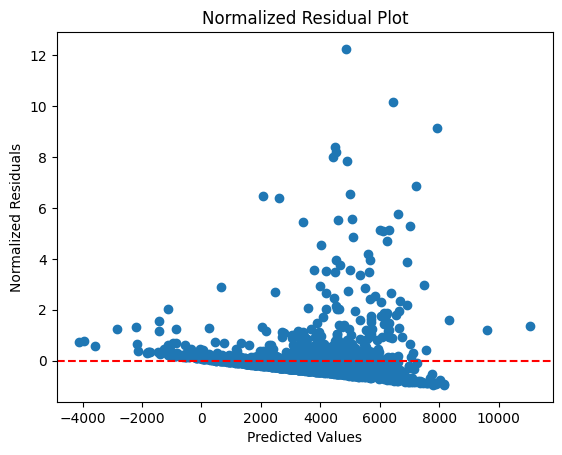

In [5]:

# Calculate the residuals
residuals = y_test - y_pred_test

# Normalize the residuals
normalized_residuals = residuals / np.std(residuals)

# Plot the normalized residuals against the predicted values
plt.scatter(y_pred_test, normalized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Normalized Residuals')
plt.title('Normalized Residual Plot')
plt.show()

Control for ``Year``, because it is not in our control

In [6]:


# Prepare data for modeling
X = popular_cleaned_data_num[['rating_average', 'minplayers', 'maxplayers', 'minage', 'playingtime']]
y = popular_cleaned_data_num['owned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
residuals = y_train - y_pred_train
_, p_value = stats.ttest_1samp(residuals, 0)

print("p-value:", p_value)
print(f"R² score on training data: {r2_train}")
print(f"R² score on test data: {r2_test}")
print(f"Mean Absolute Error on training data: {mae_train}")
print(f"Mean Absolute Error on test data: {mae_test}")
print(f"Mean Squared Error on training data: {mse_train}")
print(f"Mean Squared Error on test data: {mse_test}")

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)





p-value: 0.9999999999999978
R² score on training data: 0.045132311848460116
R² score on test data: 0.05528834106794844
Mean Absolute Error on training data: 3505.0118380578515
Mean Absolute Error on test data: 3565.7633292162027
Mean Squared Error on training data: 68370088.31791759
Mean Squared Error on test data: 58435408.232680894

Model Coefficients:
                Coefficient
rating_average  1860.482012
minplayers       293.186671
maxplayers        99.319686
minage           -21.823449
playingtime     -406.330579


In [7]:

# Prepare data for modeling
X_full = popular_cleaned_data_num[['rating_average', 'minplayers', 'maxplayers', 'minage', 'playingtime']]
X_reduced = popular_cleaned_data_num[['minplayers', 'maxplayers', 'minage', 'playingtime']]
y = popular_cleaned_data_num['owned']

# Split the data
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
X_train_reduced, X_test_reduced, _, _ = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Standardize the data
scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_full)
X_test_full_scaled = scaler_full.transform(X_test_full)

scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

# Add a constant term for the intercept in statsmodels
X_train_full_scaled = sm.add_constant(X_train_full_scaled)
X_test_full_scaled = sm.add_constant(X_test_full_scaled)
X_train_reduced_scaled = sm.add_constant(X_train_reduced_scaled)
X_test_reduced_scaled = sm.add_constant(X_test_reduced_scaled)

# Fit the models using statsmodels
model_full = sm.OLS(y_train, X_train_full_scaled).fit()
model_reduced = sm.OLS(y_train, X_train_reduced_scaled).fit()

# Get the model summaries
summary_full = model_full.summary()
summary_reduced = model_reduced.summary()
print("Full Model Summary:")
print(summary_full)
print("\nModel excluding Owned, YearPublished - Summary:")
print(summary_reduced)

# Predict on the test data
y_pred_test_full = model_full.predict(X_test_full_scaled)
y_pred_test_reduced = model_reduced.predict(X_test_reduced_scaled)



# Get the summary table
summary_full = model_full.summary()

# Extract the desired statistics
dep_variable = summary_full.tables[0].data[0][1]
r_squared = float(summary_full.tables[0].data[0][3])
adj_r_squared = float(summary_full.tables[0].data[1][3])
f_statistic = float(summary_full.tables[0].data[2][3])
df_residuals = (summary_full.tables[0].data[6][1])
df_model_only = (summary_full.tables[0].data[7][1])

# Create a new table to display the statistics
table_data = [
    ['Dep. Variable:', dep_variable],
    ['R-squared:', r_squared],
    ['Adj. R-squared:', adj_r_squared],
    ['F-statistic:', f_statistic],
    ['DF Residuals:', df_residuals],
    ['DF Model only:', df_model_only]
]

table_headers = ['Statistic', 'Value']

# Display the table
print(tabulate(table_data, headers=table_headers))


# Get the summary table
summary_reduced = model_reduced.summary()

# Extract the desired statistics
dep_variable = summary_reduced.tables[0].data[0][1]
r_squared = float(summary_reduced.tables[0].data[0][3])
adj_r_squared = float(summary_reduced.tables[0].data[1][3])
f_statistic = float(summary_reduced.tables[0].data[2][3])
df_residuals = (summary_reduced.tables[0].data[6][1])
df_model_only = (summary_reduced.tables[0].data[7][1])

# Create a new table to display the statistics
table_data = [
    ['Dep. Variable:', dep_variable],
    ['R-squared:', r_squared],
    ['Adj. R-squared:', adj_r_squared],
    ['F-statistic:', f_statistic],
    ['DF Residuals:', df_residuals],
    ['DF Model only:', df_model_only]
]

table_headers = ['Statistic', 'Value']

# Display the table
print(tabulate(table_data, headers=table_headers))


# OLS Full Model Summary
ols_full_summary = model_full.summary()
ols_full_table = ols_full_summary.tables[1]
ols_full_headers = ols_full_table.pop(0)
ols_full_table_markdown = tabulate(ols_full_table, headers=ols_full_headers, tablefmt="pipe")

# OLS Reduced Model Summary
ols_reduced_summary = model_reduced.summary()
ols_reduced_table = ols_reduced_summary.tables[1]
ols_reduced_headers = ols_reduced_table.pop(0)
ols_reduced_table_markdown = tabulate(ols_reduced_table, headers=ols_reduced_headers, tablefmt="pipe")

print("OLS Full Model Summary:")
print(ols_full_table_markdown)
print("\nOLS Reduced Model Summary:")
print(ols_reduced_table_markdown)

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  owned   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     61.97
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.51e-63
Time:                        08:21:07   Log-Likelihood:                -68491.
No. Observations:                6561   AIC:                         1.370e+05
Df Residuals:                    6555   BIC:                         1.370e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3558.4815    102.128

In [8]:
cleaned_data

,num_rating,id,name,year,rating_rank,rating_average,rating_bayes_average,rating_users_rated,num_details,primary,...,minage,boardgamecategory,boardgamemechanic,boardgamefamily,boardgameexpansion,boardgameimplementation,owned,trading,wanting,wishing
0,105,30549,Pandemic,2008,106,7.59,7.487,108975,0,Pandemic,...,8,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...",['Pandemic: Gen Con 2016 Promos – Z-Force Team...,"['Pandemic Legacy: Season 0', 'Pandemic Legacy...",168364,2508,625,9344
1,189,822,Carcassonne,2000,190,7.42,7.309,108738,1,Carcassonne,...,7,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...","['Cities: Carcassonne (France)', 'Components: ...","['20 Jahre Darmstadt Spielt', 'Apothecaries (f...","['The Ark of the Covenant', 'Carcassonne für 2...",161299,1716,582,7383
2,428,13,Catan,1995,429,7.14,6.970,108024,2,Catan,...,10,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...","['Animals: Sheep', 'Components: Hexagonal Tile...","['20 Jahre Darmstadt Spielt', 'Brettspiel Adve...","['Baden-Württemberg Catan', 'Catan Geographies...",167733,2018,485,5890
3,72,68448,7 Wonders,2010,73,7.74,7.634,89982,3,7 Wonders,...,10,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Drafting', 'Hand Management', 'Set Collectio...","['Ancient: Babylon', 'Ancient: Egypt', 'Ancien...","['7 Wonders: Armada', '7 Wonders: Babel', '7 W...","['7 Wonders (Second Edition)', '7 Wonders Duel...",120466,1567,1010,12105
4,103,36218,Dominion,2008,104,7.61,7.499,81561,4,Dominion,...,13,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...","['Crowdfunding: Wspieram', 'Game: Dominion', '...","['Ancient Times (fan expansion for Dominion)',...","['Dominion (Second Edition)', 'Het Koninkrijk ...",106956,2009,655,8621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21626,12748,296892,Sacred Rites,2020,12749,7.37,5.531,30,21626,Sacred Rites,...,8,"['Bluffing', 'Deduction', 'Humor', 'Party Game...","['Acting', 'Roles with Asymmetric Information'...",NaN,NaN,NaN,112,8,4,32
21627,15016,217378,BABEL,2016,15017,6.61,5.517,30,21627,BABEL,...,10,"['Action / Dexterity', 'Bluffing', 'Card Game'...","['Cooperative Game', 'Hand Management']","['Ancient: Babylon', 'Ancient: Mesopotamia']",['BABEL: 0'],NaN,64,1,6,21
21628,19459,18063,Goldrush,1970,19460,5.00,5.488,30,21628,Goldrush,...,10,"['American West', 'Dice', 'Exploration', 'Figh...","['Dice Rolling', 'Memory', 'Pick-up and Delive...",['States: Arizona'],NaN,NaN,98,7,4,5
21629,17256,10052,Bongo Kongo,1989,17257,5.80,5.505,30,21629,Bongo Kongo,...,5,"['Action / Dexterity', 'Animals', ""Children's ...",NaN,"['Animals: Apes / Monkeys', 'Components: Marbl...",NaN,NaN,52,4,8,13


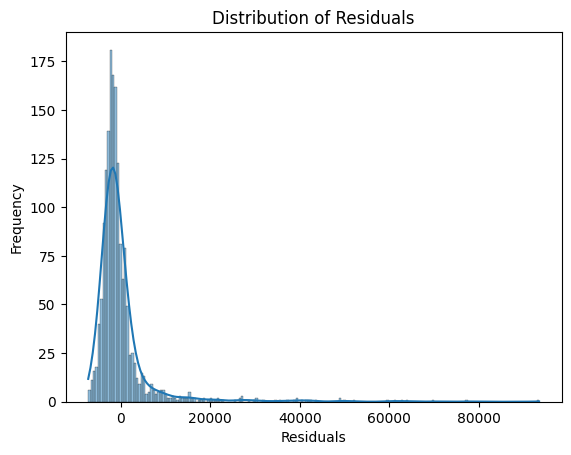

In [9]:
# Calculate the residuals
residuals = y_test - y_pred_test_full 

# Plot the distribution of residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()